# 🌍 Projet Incendies — Nettoyage, EDA & Modélisation

Ce projet s’inscrit dans le cadre de l’étude **“Terre, Vent, Feu, Eau, Data”**, avec un objectif clair :  
👉 exploiter les données historiques des incendies en France (BDIFF + référentiel des communes) pour mieux comprendre leurs causes, leur répartition, et tenter de prédire les risques.

---

## 🎯 Objectifs du projet

1. **Exploration des données**  
   - Connexion à une base **SQLite** contenant :
     - Les incendies (`incendies`),  
     - Les communes (`communes`),  
     - Une table enrichie (`incendies_communes`).  
   - Vérification de la structure et du contenu des tables.

2. **Nettoyage & préparation**  
   - Gestion des valeurs **manquantes** (lat/lon, surfaces, causes).  
   - Suppression ou gestion des **doublons**.  
   - Détection et traitement des **outliers** (ex: surfaces négatives ou aberrantes).  
   - Regroupement des **catégories rares** (dans les causes d’incendie).

3. **Analyse exploratoire (EDA)**  
   - Distribution temporelle (par année, saison, mois).  
   - Distribution spatiale (par département, communes).  
   - Analyse des surfaces brûlées et de leurs facteurs.  
   - Visualisations (courbes, histogrammes, camemberts, cartes).

4. **Modélisation (Machine Learning)**  
   - Construction d’une variable cible : **incendie majeur** (ex: surface > 10 ha).  
   - Features candidates : année, département, type de peuplement, cause, météo (si disponible)…  
   - Modèle de base : **Random Forest** pour prédire la probabilité d’un incendie majeur.  
   - Évaluation : matrice de confusion, précision, rappel, F1-score.

---

## 0) Les Imports

In [3]:
# === Imports ===
import sqlite3
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_curve, average_precision_score, roc_auc_score,
    classification_report, confusion_matrix, precision_score, recall_score, f1_score
)
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier

from rapidfuzz.fuzz import partial_ratio

# === Paramètres généraux ===
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)

plt.rcParams['figure.figsize'] = (9,5)

# === Chemins / Tables ===
db_path = "../data/incendies.db"      
table_name = "incendies_communes"           

Path(db_path).exists(), db_path


(True, '../data/incendies.db')

## 1. **Exploration des données** 

In [4]:
# Connexion à la base
con = sqlite3.connect(db_path)

# Nombre de lignes par table + nb de colonnes (approx via PRAGMA)
def table_shape(connection):
    out = []
    
    for t in ['incendies', 'communes', 'incendies_communes']:
        n = pd.read_sql(f"SELECT COUNT(*) AS n FROM {t};", connection).iloc[0,0]
        cols = pd.read_sql(f"PRAGMA table_info({t});", connection)
        out.append({"Table": t, "Linges": n, "Colonnes": len(cols)})
    return pd.DataFrame(out).sort_values("Linges", ascending=False)

table_shapes = table_shape(con)
table_shapes


Table  Linges  Colonnes
0           incendies  128916        25
2  incendies_communes  128916        18
1            communes   34935        48

> **Note :** Pour voir la taille de chacune de mes table 

### 1. Inspection initiale

In [5]:
sample_rows = 200_000  
try:
    df = pd.read_sql(f"SELECT * FROM {table_name} LIMIT {sample_rows};", con)
except Exception as e:
    print("Erreur de lecture : ", e)
    raise

print("Shape (sample):", df.shape)
df.head(3)


Shape (sample): (128916, 18)


annee numero departement code_insee  commune_incendie          date_alerte surface_parcourue_m2 type_peuplement nature nb_deces  \
0  1978    636          11      11262          Narbonne  1978-01-01 03:20:00                 1000               1                   
1  1978    750          13      13051   Lançon-Provence  1978-01-01 12:51:00                 8000               1                   
2  1978   3779          83      83063  La Garde-Freinet  1978-01-01 16:10:00                15000               4                   

  nb_batiments_totalement_detruits nb_batiments_partiellement_detruits       commune_ref     lat    lon population superficie_km2 densite  
0                                                                               Narbonne  43.165   3.02      56395            175   323.0  
1                                                                        Lançon-Provence  43.576   5.16       9340             69   135.0  
2                                                                       La Garde-Freinet  43.323  6.467       1831             77    24.0

### 📝 Tableau des Features

| Colonne                             | Définition / Description |
|-------------------------------------|--------------------------|
| **annee**                           | Année civile de l’incendie (AAAA). |
| **numero**                          | Numéro unique de l’incendie dans l’année. |
| **departement**                     | Code du département où l’incendie a eu lieu. |
| **code_insee**                      | Code INSEE de la commune concernée. |
| **commune_incendie**                | Nom de la commune où l’incendie a démarré. |
| **date_alerte**                     | Date et heure où le départ de feu est signalé au CODIS. |
| **surface_parcourue_m2**            | Surface totale parcourue par le feu (m²), toutes végétations confondues. |
| **type_peuplement**                 | Type de formation végétale principalement touchée : landes/garrigues/maquis, taillis, futaies feuillues, futaies résineuses, futaies mélangées, régénération ou reboisement. |
| **nature**                          | Origine de l’incendie (si connue) : naturelle, accidentelle, malveillance, involontaire (travaux), involontaire (particulier). |
| **nb_deces**                        | Nombre de décès directement liés à l’incendie. |
| **nb_batiments_totalement_detruits**| Nombre de bâtiments détruits (toiture effondrée, structure inutilisable). |
| **nb_batiments_partiellement_detruits** | Nombre de bâtiments endommagés mais partiellement utilisables. |
| **commune_ref**                     | Référence normalisée de la commune (ex. correspondance INSEE). |
| **lat**                             | Latitude de la commune / du centre du feu. |
| **lon**                             | Longitude de la commune / du centre du feu. |
| **population**                      | Population de la commune (données INSEE). |
| **superficie_km2**                  | Superficie totale de la commune en km². |
| **densite**                         | Densité de population (hab./km²). |


In [6]:
# La table enrichie contient 128916 lignes et 18 colonnes.
df.shape

(128916, 18)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128916 entries, 0 to 128915
Data columns (total 18 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   annee                                128916 non-null  object
 1   numero                               128916 non-null  object
 2   departement                          128916 non-null  object
 3   code_insee                           128916 non-null  object
 4   commune_incendie                     128916 non-null  object
 5   date_alerte                          128916 non-null  object
 6   surface_parcourue_m2                 128916 non-null  object
 7   type_peuplement                      128916 non-null  object
 8   nature                               128916 non-null  object
 9   nb_deces                             128916 non-null  object
 10  nb_batiments_totalement_detruits     128916 non-null  object
 11  nb_batiments_partiellement

> **Note :**  Présence de valeurs manquantes dans plusieurs colonnes et types de données à ajuster.

### Manipulation des valeurs manquantes

In [8]:
def detecter_valeurs_manquantes(df):
    # Remplace les chaînes vides ou espaces par NaN
    df_clean = df.replace(r'^\s*$', np.nan, regex=True)
    
    # Nombre et pourcentage
    missing = df_clean.isna().sum().to_frame("nb_valeurs_manquantes")
    missing["pourcentage"] = (missing["nb_valeurs_manquantes"] / len(df_clean) * 100).round(2)
    
    return missing.sort_values("nb_valeurs_manquantes", ascending=False)


> **Note** : J'avais creer une fonction qui ne détecte pas les chaînes vides ou espaces.
La fonction précédente remplace les chaînes vides ou espaces par NaN avant de faire les calculs.


In [9]:
detecter_valeurs_manquantes(df)

nb_valeurs_manquantes  pourcentage
nb_batiments_partiellement_detruits                 128041        99.32
nb_deces                                            128041        99.32
nb_batiments_totalement_detruits                    128040        99.32
nature                                               81552        63.26
type_peuplement                                      59094        45.84
lat                                                   1612         1.25
lon                                                   1612         1.25
population                                             881         0.68
superficie_km2                                         881         0.68
commune_ref                                            881         0.68
densite                                                881         0.68
commune_incendie                                        27         0.02
numero                                                   0         0.00
annee                                                    0         0.00
surface_parcourue_m2                                     0         0.00
departement                                              0         0.00
code_insee                                               0         0.00
date_alerte                                              0         0.00

In [10]:
df = df.drop(columns=[
    "nb_batiments_partiellement_detruits",
    "nb_batiments_totalement_detruits",
    "nb_deces"
])

> **Note**: Supprimer les colonnes qui présentent beaucoup de valeurs manquantes

In [11]:
# Remplacer les valeurs manquantes de `nature` par `Inconnu`
df["nature"] = df["nature"].replace(r'^\s*$', "Inconnu", regex=True).fillna("Inconnu")

> **Note**: J'ai décidé de remplacer les valeurs manquantes de `nature` par `Inconnu`


In [12]:
detecter_valeurs_manquantes(df)

nb_valeurs_manquantes  pourcentage
type_peuplement                       59094        45.84
lat                                    1612         1.25
lon                                    1612         1.25
commune_ref                             881         0.68
densite                                 881         0.68
population                              881         0.68
superficie_km2                          881         0.68
commune_incendie                         27         0.02
date_alerte                               0         0.00
surface_parcourue_m2                      0         0.00
departement                               0         0.00
annee                                     0         0.00
numero                                    0         0.00
code_insee                                0         0.00
nature                                    0         0.00

In [13]:
df['type_peuplement'].unique()

array(['1', '4', '5', '', '3', '6', 'Type de peuplement', '2'],
      dtype=object)

> **Note** : 

D’après la documentation BDIFF, les codes de cette colonne correspondent probablement à :

| Code | Libellé                          |
|------|----------------------------------|
| 1    | Landes / Garrigues / Maquis      |
| 2    | Taillis                          |
| 3    | Futaies feuillues                |
| 4    | Futaies résineuses               |
| 5    | Futaies mélangées                |
| 6    | Régénération / Reboisement       |

Dans ce cas je vais remplacé les valeurs manquantes et (` ` et `Type de peuplement`) par `7`

In [14]:
# Remplacer les valeurs vides ou parasites ('', 'Type de peuplement') par "7" (Autre)
df["type_peuplement"] = (
    df["type_peuplement"]
    .replace({r'^\s*$': np.nan, "Type de peuplement": np.nan}, regex=True)  # vides + parasite
    .fillna("7")  # insère "7" (chaîne → objet)
    .astype(str)  # force toute la colonne en objet (string)
)


In [15]:
# Pour s'assurer que tout est ok
df["type_peuplement"].unique() 

array(['1', '4', '5', '7', '3', '6', '2'], dtype=object)

In [16]:
detecter_valeurs_manquantes(df)

nb_valeurs_manquantes  pourcentage
lat                                    1612         1.25
lon                                    1612         1.25
population                              881         0.68
commune_ref                             881         0.68
superficie_km2                          881         0.68
densite                                 881         0.68
commune_incendie                         27         0.02
surface_parcourue_m2                      0         0.00
date_alerte                               0         0.00
code_insee                                0         0.00
departement                               0         0.00
annee                                     0         0.00
numero                                    0         0.00
type_peuplement                           0         0.00
nature                                    0         0.00

In [17]:
# Supprimer les lignes avec des valeurs manquantes dans n'importe quelle colonne
df = df.replace({r'^\s*$': np.nan, r'^\.\.$': np.nan}, regex=True).dropna(how="any")


In [18]:
detecter_valeurs_manquantes(df)

nb_valeurs_manquantes  pourcentage
annee                                     0          0.0
numero                                    0          0.0
departement                               0          0.0
code_insee                                0          0.0
commune_incendie                          0          0.0
date_alerte                               0          0.0
surface_parcourue_m2                      0          0.0
type_peuplement                           0          0.0
nature                                    0          0.0
commune_ref                               0          0.0
lat                                       0          0.0
lon                                       0          0.0
population                                0          0.0
superficie_km2                            0          0.0
densite                                   0          0.0

### Manipulation des doublons

In [19]:
def detecter_doublons(df, subset=None):
    """
    Détecte les doublons dans un DataFrame.
    
    Paramètres
    ----------
    df : pd.DataFrame
        Le DataFrame à analyser
    subset : list ou None
        Colonnes sur lesquelles vérifier les doublons (par défaut toutes les colonnes)
   
    """
    return df[df.duplicated(subset=subset, keep=False)].sort_values(by=subset if subset else df.columns.tolist())


In [20]:
# Montrer les doublons
detecter_doublons(df, df.columns.tolist())

annee numero departement code_insee  commune_incendie          date_alerte surface_parcourue_m2 type_peuplement  \
39486  1989   2681          83      83063  La Garde-Freinet  1989-03-26 14:50:00                 1000               1   
39487  1989   2681          83      83063  La Garde-Freinet  1989-03-26 14:50:00                 1000               1   

                       nature       commune_ref     lat    lon population superficie_km2 densite  
39486  Involontaire (travaux)  La Garde-Freinet  43.323  6.467       1831             77    24.0  
39487  Involontaire (travaux)  La Garde-Freinet  43.323  6.467       1831             77    24.0

In [21]:
# Supprimer les doublons
df = df.drop_duplicates()

In [22]:
detecter_doublons(df, df.columns.tolist())

Empty DataFrame
Columns: [annee, numero, departement, code_insee, commune_incendie, date_alerte, surface_parcourue_m2, type_peuplement, nature, commune_ref, lat, lon, population, superficie_km2, densite]
Index: []

## 3) Parsing des dates & heures

In [23]:
# Conversion de colonnes en numériques
def convert_to_numeric(df, cols):

    for col in cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

In [24]:
# df.drop(columns=["annee"], inplace=True) 

# Conversion en datetime 
df["date_alerte"] = pd.to_datetime(df["date_alerte"], errors="coerce")

# Extraire composantes temporelles
# df["annee"] = df["date_alerte"].dt.year
df["mois"]  = df["date_alerte"].dt.month
df["jour"]  = df["date_alerte"].dt.day
df["heure"] = df["date_alerte"].dt.hour   # heure numérique (0–23)

# Supprimer la colonne d’origine
df.drop(columns=["date_alerte"], inplace=True)

# Vérification
df.head()


annee numero departement code_insee      commune_incendie surface_parcourue_m2 type_peuplement   nature           commune_ref     lat  \
0  1978    636          11      11262              Narbonne                 1000               1  Inconnu              Narbonne  43.165   
1  1978    750          13      13051       Lançon-Provence                 8000               1  Inconnu       Lançon-Provence  43.576   
2  1978   3779          83      83063      La Garde-Freinet                15000               4  Inconnu      La Garde-Freinet  43.323   
3  1978   3780          83      83126      La Seyne-sur-Mer                 1000               5  Inconnu      La Seyne-sur-Mer  43.088   
4  1978    751          13      13085  Roquefort-la-Bédoule                 1000               1  Inconnu  Roquefort-la-Bédoule  43.251   

     lon population superficie_km2 densite  mois  jour  heure  
0   3.02      56395            175   323.0     1     1      3  
1   5.16       9340             69   135.0     1     1     12  
2  6.467       1831             77    24.0     1     1     16  
3  5.871      62763             24  2664.0     1     3     16  
4  5.629       5861             31   189.0     1     3     17

## <a id='features'></a>6) Feature engineering

In [25]:
# Renommer les colonnes pour plus de clarté et cohérence

df.rename(columns={
    "numero": "numero_incendie",
    "departement": "code_departement",
    "surface_parcourue_m2": "surface_brulee_m2",
    "nature": "nature_incendie",
    "lat": "latitude",
    "lon": "longitude",
    "population": "population_commune",
    "densite": "densite_population"
}, inplace=True)

df


annee numero_incendie code_departement code_insee      commune_incendie surface_brulee_m2 type_peuplement  \
0       1978             636               11      11262              Narbonne              1000               1   
1       1978             750               13      13051       Lançon-Provence              8000               1   
2       1978            3779               83      83063      La Garde-Freinet             15000               4   
3       1978            3780               83      83126      La Seyne-sur-Mer              1000               5   
4       1978             751               13      13085  Roquefort-la-Bédoule              1000               1   
...      ...             ...              ...        ...                   ...               ...             ...   
128911  2022           11134               64      64545               Urrugne                 5               7   
128912  2022           21656               66      66192                 Sauto               300               5   
128913  2022           21658               66      66118               Montner               300               1   
128914  2022           12005               33      33051               Biganos                 8               7   
128915  2022           21725               2A      2A048           Calcatoggio                50               7   

                   nature_incendie           commune_ref latitude longitude population_commune superficie_km2 densite_population  mois  \
0                          Inconnu              Narbonne   43.165      3.02              56395            175              323.0     1   
1                          Inconnu       Lançon-Provence   43.576      5.16               9340             69              135.0     1   
2                          Inconnu      La Garde-Freinet   43.323     6.467               1831             77               24.0     1   
3                          Inconnu      La Seyne-sur-Mer   43.088     5.871              62763             24             2664.0     1   
4                          Inconnu  Roquefort-la-Bédoule   43.251     5.629               5861             31              189.0     1   
...                            ...                   ...      ...       ...                ...            ...                ...   ...   
128911                     Inconnu               Urrugne    43.35    -1.697              10543             52              201.0    12   
128912                Accidentelle                 Sauto   42.516     2.149                 98              8               12.0    12   
128913                Malveillance               Montner   42.741     2.688                331             11               30.0    12   
128914                Malveillance               Biganos   44.661    -0.949              11095             51              217.0    12   
128915  Involontaire (particulier)           Calcatoggio   42.028     8.738                507             23               22.0    12   

        jour  heure  
0          1      3  
1          1     12  
2          1     16  
3          3     16  
4          3     17  
...      ...    ...  
128911    26     15  
128912    27     14  
128913    30     22  
128914    31     16  
128915    31     17  

[127302 rows x 17 columns]

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127302 entries, 0 to 128915
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   annee               127302 non-null  object
 1   numero_incendie     127302 non-null  object
 2   code_departement    127302 non-null  object
 3   code_insee          127302 non-null  object
 4   commune_incendie    127302 non-null  object
 5   surface_brulee_m2   127302 non-null  object
 6   type_peuplement     127302 non-null  object
 7   nature_incendie     127302 non-null  object
 8   commune_ref         127302 non-null  object
 9   latitude            127302 non-null  object
 10  longitude           127302 non-null  object
 11  population_commune  127302 non-null  object
 12  superficie_km2      127302 non-null  object
 13  densite_population  127302 non-null  object
 14  mois                127302 non-null  int32 
 15  jour                127302 non-null  int32 
 16  heure  

In [27]:
#   Nettoyage de la colonne 'type_peuplement'
# - Convertir les valeurs en numérique (codes 1 à 7)

convert_to_numeric(df, ['type_peuplement'])

# Mapping des codes BDIFF vers libellés
mapping_peuplement = {
    1: "Landes/garrigues/maquis",
    2: "Taillis",
    3: "Futaies feuillues",
    4: "Futaies résineuses",
    5: "Futaies mélangées",
    6: "Régénération/Reboisement",
    7: "Inconnu"
}

# Ajouter une colonne texte avec le libellé correspondant
df['type_peuplement_label'] = df['type_peuplement'].map(mapping_peuplement)

In [28]:
detecter_valeurs_manquantes(df)

nb_valeurs_manquantes  pourcentage
annee                                      0          0.0
numero_incendie                            0          0.0
code_departement                           0          0.0
code_insee                                 0          0.0
commune_incendie                           0          0.0
surface_brulee_m2                          0          0.0
type_peuplement                            0          0.0
nature_incendie                            0          0.0
commune_ref                                0          0.0
latitude                                   0          0.0
longitude                                  0          0.0
population_commune                         0          0.0
superficie_km2                             0          0.0
densite_population                         0          0.0
mois                                       0          0.0
jour                                       0          0.0
heure                                      0          0.0
type_peuplement_label                      0          0.0

In [29]:
# Conversion de colonnes en numérique 
cols = ['numero_incendie', 'surface_brulee_m2', 'latitude', 'longitude',
        'population_commune', 'superficie_km2', 'densite_population']

convert_to_numeric(df, cols)

annee  numero_incendie code_departement code_insee      commune_incendie  surface_brulee_m2  type_peuplement  \
0       1978              636               11      11262              Narbonne               1000                1   
1       1978              750               13      13051       Lançon-Provence               8000                1   
2       1978             3779               83      83063      La Garde-Freinet              15000                4   
3       1978             3780               83      83126      La Seyne-sur-Mer               1000                5   
4       1978              751               13      13085  Roquefort-la-Bédoule               1000                1   
...      ...              ...              ...        ...                   ...                ...              ...   
128911  2022            11134               64      64545               Urrugne                  5                7   
128912  2022            21656               66      66192                 Sauto                300                5   
128913  2022            21658               66      66118               Montner                300                1   
128914  2022            12005               33      33051               Biganos                  8                7   
128915  2022            21725               2A      2A048           Calcatoggio                 50                7   

                   nature_incendie           commune_ref  latitude  longitude  population_commune  superficie_km2  densite_population  \
0                          Inconnu              Narbonne    43.165      3.020               56395             175               323.0   
1                          Inconnu       Lançon-Provence    43.576      5.160                9340              69               135.0   
2                          Inconnu      La Garde-Freinet    43.323      6.467                1831              77                24.0   
3                          Inconnu      La Seyne-sur-Mer    43.088      5.871               62763              24              2664.0   
4                          Inconnu  Roquefort-la-Bédoule    43.251      5.629                5861              31               189.0   
...                            ...                   ...       ...        ...                 ...             ...                 ...   
128911                     Inconnu               Urrugne    43.350     -1.697               10543              52               201.0   
128912                Accidentelle                 Sauto    42.516      2.149                  98               8                12.0   
128913                Malveillance               Montner    42.741      2.688                 331              11                30.0   
128914                Malveillance               Biganos    44.661     -0.949               11095              51               217.0   
128915  Involontaire (particulier)           Calcatoggio    42.028      8.738                 507              23                22.0   

        mois  jour  heure    type_peuplement_label  
0          1     1      3  Landes/garrigues/maquis  
1          1     1     12  Landes/garrigues/maquis  
2          1     1     16       Futaies résineuses  
3          1     3     16        Futaies mélangées  
4          1     3     17  Landes/garrigues/maquis  
...      ...   ...    ...                      ...  
128911    12    26     15                  Inconnu  
128912    12    27     14        Futaies mélangées  
128913    12    30     22  Landes/garrigues/maquis  
128914    12    31     16                  Inconnu  
128915    12    31     17                  Inconnu  

[127302 rows x 18 columns]

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127302 entries, 0 to 128915
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   annee                  127302 non-null  object 
 1   numero_incendie        127302 non-null  int64  
 2   code_departement       127302 non-null  object 
 3   code_insee             127302 non-null  object 
 4   commune_incendie       127302 non-null  object 
 5   surface_brulee_m2      127302 non-null  int64  
 6   type_peuplement        127302 non-null  int64  
 7   nature_incendie        127302 non-null  object 
 8   commune_ref            127302 non-null  object 
 9   latitude               127302 non-null  float64
 10  longitude              127302 non-null  float64
 11  population_commune     127302 non-null  int64  
 12  superficie_km2         127302 non-null  int64  
 13  densite_population     127302 non-null  float64
 14  mois                   127302 non-null  i

In [31]:
df["code_insee"] = df["code_insee"].str.upper()

In [32]:
# Table de référence communes
df_communes = pd.read_sql("SELECT code_insee FROM communes;", con)
df_communes["code_insee"].unique()

array(['01001', '01002', '01004', ..., '97615', '97616', '97617'],
      shape=(34935,), dtype=object)

In [33]:
# Comparer avec ton DataFrame incendies
codes_absents = set(df["code_insee"]) - set(df_communes["code_insee"])

# Affichage
print(f"Nombre de codes absents : {len(codes_absents)}")
print("Liste des codes absents :", codes_absents)

Nombre de codes absents : 0
Liste des codes absents : set()


> **Note** :

Lors du contrôle de cohérence entre les codes INSEE de mon DataFrame `df` et ceux de la table de référence `communes`,   j’ai détecté **358 codes considérés comme absents**.

En réalité, il s’agissait des communes corses, dont les codes commencent par `2A` ou `2B`.  
Dans mon DataFrame, ces codes apparaissaient en minuscules (`2a`, `2b`), alors que dans la table de référence ils étaient en majuscules (`2A`, `2B`).  
Cela a faussé la comparaison initiale.

✅ Solution appliquée :  
- Normaliser tous les codes INSEE en majuscules 

In [34]:
# Comparer les 2 colonnes de noms de communes
def norm(s: str) -> str:
    if pd.isna(s): return ""
    s = (s.lower()
           .replace("'", " ")
           .replace("-", " ")
           .replace("’", " ")
           .replace("‐", " ")
           .replace("–", " ")
           .replace("—", " "))
    s = "".join(ch for ch in s if ch.isalnum() or ch.isspace())
    return " ".join(s.split())

# Comparer avec arrondi de la similarité
df_incoh = (
    df.assign(
        similarite = df.apply(lambda r: round(
            partial_ratio(norm(r["commune_incendie"]),
                          norm(r["commune_ref"])), 0), axis=1),
        match_commune = lambda d: d["similarite"] >= 90
    )
    .loc[lambda d: ~d["match_commune"], ["code_insee","commune_incendie","commune_ref","similarite"]]
    .sort_values("similarite")
    .head(30)
)

# Rapport rapide
nb_ok = len(df) - len(df_incoh)
nb_ko = len(df_incoh)
print(f"====> Correspondances (≈ mêmes noms) : {nb_ok}")
print(f"xxxx> A examiner (noms divergents)   : {nb_ko}")

df_incoh


====> Correspondances (≈ mêmes noms) : 127272
xxxx> A examiner (noms divergents)   : 30


code_insee         commune_incendie               commune_ref  similarite
109401      24117                Chavagnac  Les Coteaux Périgourdins        24.0
99518       24117                Chavagnac  Les Coteaux Périgourdins        24.0
91102       24117                Chavagnac  Les Coteaux Périgourdins        24.0
114326      11251                 Montlaur              Val-de-Dagne        25.0
107845      11251                 Montlaur              Val-de-Dagne        25.0
108547      11251                 Montlaur              Val-de-Dagne        25.0
107373      11251                 Montlaur              Val-de-Dagne        25.0
77912       11251                 Montlaur              Val-de-Dagne        25.0
105265      11251                 Montlaur              Val-de-Dagne        25.0
106713      11251                 Montlaur              Val-de-Dagne        25.0
93601       33008                    Arbis          Porte-de-Benauge        25.0
90612       11251                 Montlaur              Val-de-Dagne        25.0
68518       05118                  Ribiers          Val Buëch-Méouge        25.0
62513       11251                 Montlaur              Val-de-Dagne        25.0
84821       11251                 Montlaur              Val-de-Dagne        25.0
78074       26210               Montrigaud               Valherbasse        25.0
34033       05118                  Ribiers          Val Buëch-Méouge        25.0
101076      05024                    Bruis                  Valdoule        25.0
98353       11251                 Montlaur              Val-de-Dagne        25.0
97190       33008                    Arbis          Porte-de-Benauge        25.0
98049       11251                 Montlaur              Val-de-Dagne        25.0
52598       05024                    Bruis                  Valdoule        25.0
39366       05118                  Ribiers          Val Buëch-Méouge        25.0
37351       11251                 Montlaur              Val-de-Dagne        25.0
99126       11251                 Montlaur              Val-de-Dagne        25.0
75518       48099  Le Monastier-Pin-Moriès        Bourgs sur Colagne        29.0
28468       48099  Le Monastier-Pin-Moriès        Bourgs sur Colagne        29.0
28507       48099  Le Monastier-Pin-Moriès        Bourgs sur Colagne        29.0
52514       48099  Le Monastier-Pin-Moriès        Bourgs sur Colagne        29.0
60409       48099  Le Monastier-Pin-Moriès        Bourgs sur Colagne        29.0

#### Divergences entre `commune_incendie` et `commune_ref`

Lors de la comparaison des colonnes `commune_incendie` (provenant du dataset principale) et `commune_ref` (provenant de la table de référence INSEE),  
j'ai identifié **524 divergences**.  

Après vérification, il apparaît que ces différences sont **normales** : elles proviennent des **changements administratifs** opérés par l’INSEE, notamment des **fusions de communes** ou des **changements de noms officiels**.

##### Exemples concrets :
- `chavagnac` (`24117`) → aujourd’hui rattaché à la commune nouvelle **Les Coteaux Périgourdins** (fusion de communes en Dordogne, 2016).  
- `montlaur` (`11251`) → aujourd’hui rattaché à la commune nouvelle **Val-de-Dagne** (fusion de communes dans l’Aude, 2019).  

##### Conclusion :
- Le **code INSEE** reste la clé **stable et unique** permettant de relier les données historiques aux communes actuelles.  
- Les **noms de communes** peuvent diverger entre les sources, car ils reflètent des états différents dans le temps (avant ou après fusion).  
- Pour nos analyses, nous conserverons :
  - `commune_incendie` → nom historique issu du dataset incendies.  
  - `commune_ref` → nom officiel actuel selon le référentiel INSEE.  


### Analyse desciptive

#### 1. Variables numériques continues

In [35]:
def analyse_numeriques_continues(df, seuil_discret=30):
    """Analyse descriptive des variables numériques continues.
    """
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    cont_cols = [c for c in num_cols if df[c].nunique() >= seuil_discret]
    
    if cont_cols:
        return df[cont_cols].describe().round(1).T
    else:
        return pd.DataFrame(
            columns=[" count ", " mean ", " std ", " min ", " 25% ", " 50% ", " 75% ", " max "]
        )


In [36]:
print("=== Variables continues ===")
analyse_numeriques_continues(df)

=== Variables continues ===


count     mean        std   min     25%     50%      75%          max
numero_incendie     127302.0   4437.8     4724.4   1.0  1138.0  2479.0   6900.8      29813.0
surface_brulee_m2   127302.0  70707.8  1071993.1   1.0   500.0  2000.0  12000.0  125520000.0
latitude            127302.0     42.8        6.5 -21.3    42.5    43.4     44.1         50.7
longitude           127302.0      6.1        5.9 -61.5     3.7     5.7      8.8         55.8
population_commune  127302.0   9426.3    29175.5   1.0   452.0  1659.0   5377.0     348085.0
superficie_km2      127302.0     42.5       45.1   0.0    16.0    27.0     49.0        758.0
densite_population  127302.0    213.0      503.9   0.0    18.0    56.0    189.0       8485.0

#### Analyse des variables continues

- **surface_brulee_m2** : distribution très asymétrique. La plupart des incendies concernent de petites surfaces, mais quelques événements majeurs (jusqu’à 12 552 ha) tirent fortement la moyenne vers le haut.  
- **latitude / longitude** : valeurs globalement cohérentes avec le territoire français.  
  - La présence de points autour de (42°N, 9°E) correspond bien à la Corse.  
  - Quelques valeurs aberrantes restent à corriger (lat -21°, lon -61° hors France métropolitaine).  
- **population_commune** : forte disparité entre petites communes et grandes villes (max ≈ 348 000 hab.).  
- **superficie_km2** : valeurs cohérentes avec la taille des communes françaises (max = Arles ≈ 759 km²).  
- **densite_population** : médiane faible (zones rurales) mais valeurs extrêmes élevées dans les zones urbaines denses.  


In [37]:
cont_cols = ["surface_brulee_m2", "latitude", "longitude", "population_commune", "superficie_km2", "densite_population"]

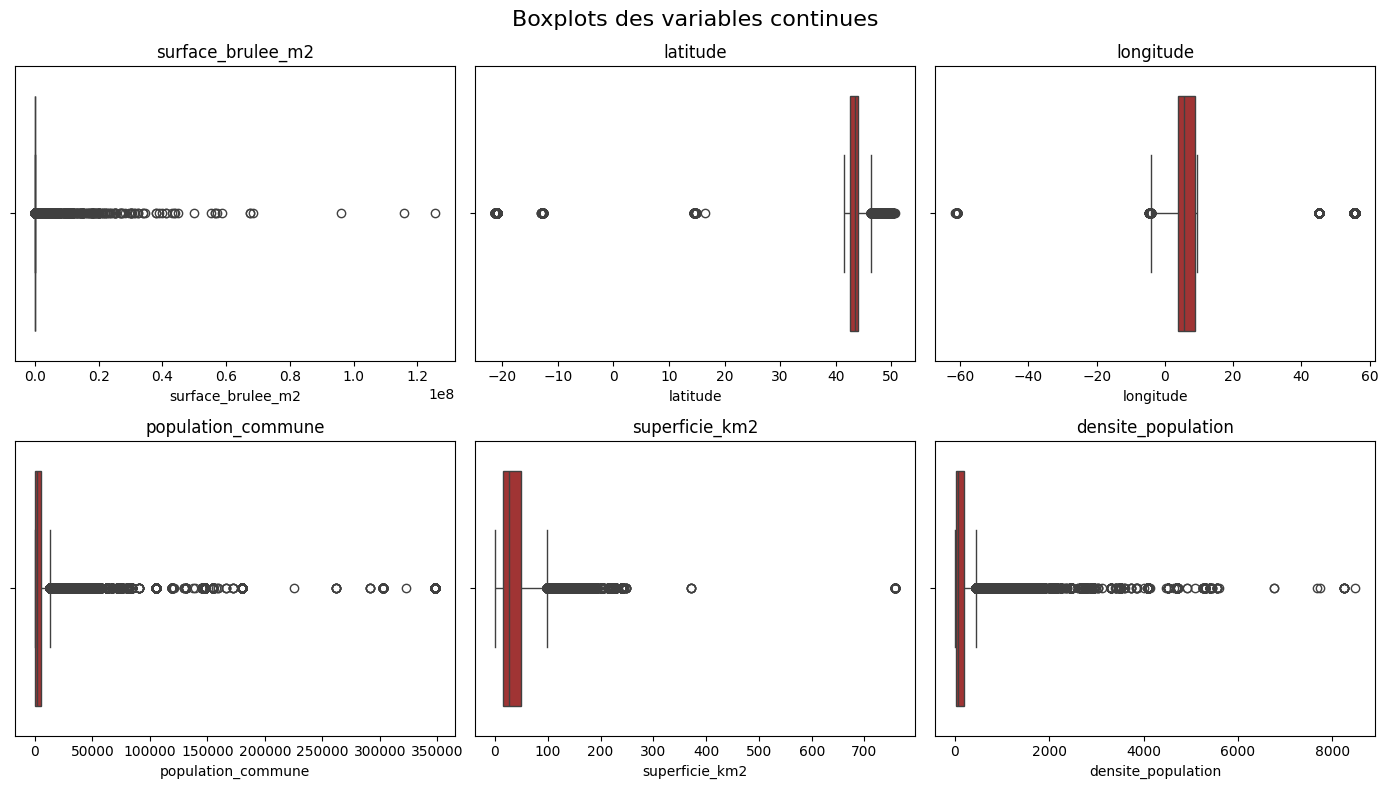

In [38]:
 # 1) Boxplots pour repérer les outliers
plt.figure(figsize=(14, 8))
for i, col in enumerate(cont_cols, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(x=df[col], color="firebrick")
        plt.title(col)
plt.suptitle("Boxplots des variables continues", fontsize=16)
plt.tight_layout()
plt.show()

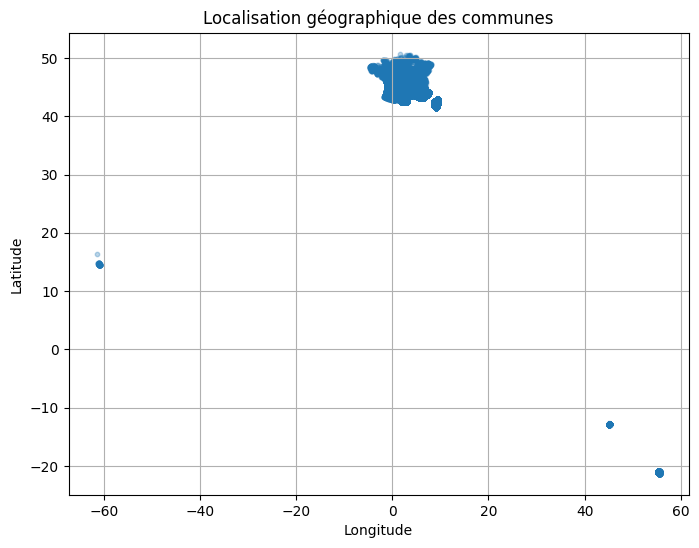

In [39]:
# 3) Carte scatter Latitude vs Longitude
plt.figure(figsize=(8, 6))
plt.scatter(df["longitude"], df["latitude"], alpha=0.3, s=10)
plt.title("Localisation géographique des communes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [40]:
df.isna().sum()

annee                    0
numero_incendie          0
code_departement         0
code_insee               0
commune_incendie         0
surface_brulee_m2        0
type_peuplement          0
nature_incendie          0
commune_ref              0
latitude                 0
longitude                0
population_commune       0
superficie_km2           0
densite_population       0
mois                     0
jour                     0
heure                    0
type_peuplement_label    0
dtype: int64

#### 2. Variables numériques discrètes

In [41]:
def analyse_numeriques_discretes(df, seuil_discret=30):
    """Analyse descriptive des variables numériques discrètes (peu de modalités)."""
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    discr_cols = [c for c in num_cols if df[c].nunique() < seuil_discret]
    if discr_cols:
        return {col: df[col].value_counts().sort_index() for col in discr_cols}
    else:
        return "Aucune variable discrète détectée"


In [42]:
print("\n=== Variables discrètes ===")
analyse_numeriques_discretes(df)


=== Variables discrètes ===


{'type_peuplement': type_peuplement
 1    49531
 2     1324
 3     4773
 4     7053
 5     4831
 6     1566
 7    58224
 Name: count, dtype: int64}

> **Note** :

#### 3. Variables qualitatives

In [43]:
def analyse_qualitatives(df, top=20):
    """Analyse descriptive des variables qualitatives (object, bool, category)."""
    cat_cols = df.select_dtypes(include=["object", "bool", "category"]).columns
    if cat_cols is not None and len(cat_cols) > 0:
        return {col: df[col].value_counts(dropna=False).head(top) for col in cat_cols}
    else:
        return "Aucune variable qualitative détectée"


In [44]:
print("\n=== Variables qualitatives ===")
print(analyse_qualitatives(df))


=== Variables qualitatives ===
{'annee': annee
2022    4405
1978    4326
1979    4092
1985    3679
1980    3509
2003    3416
1981    3406
1990    3276
1989    3265
2017    3262
2006    3204
1999    2991
2009    2965
2020    2956
1993    2936
2019    2928
2015    2915
1982    2866
2016    2850
1997    2775
Name: count, dtype: int64, 'code_departement': code_departement
2B     20554
2A     17207
83     13471
13     10112
06      7741
07      7643
34      6557
30      6144
11      5406
66      5192
33      3407
84      3087
48      2203
04      2115
40      1781
974     1090
26      1036
46       968
24       953
05       770
Name: count, dtype: int64, 'code_insee': code_insee
2A004    1840
2A272    1255
2B096     939
2A247     864
2B049     738
2A017     662
2A362     632
13056     588
13001     586
2B148     530
2B042     513
2A271     511
2B123     507
2B185     504
2A345     431
2A048     420
2A041     416
97415     416
2B143     391
06088     388
Name: count, dtype: int64, 'commune_

> **Note** : 

In [45]:
df["gravite"] = (df["surface_brulee_m2"] > 100_000).astype(int)
df

annee  numero_incendie code_departement code_insee      commune_incendie  surface_brulee_m2  type_peuplement  \
0       1978              636               11      11262              Narbonne               1000                1   
1       1978              750               13      13051       Lançon-Provence               8000                1   
2       1978             3779               83      83063      La Garde-Freinet              15000                4   
3       1978             3780               83      83126      La Seyne-sur-Mer               1000                5   
4       1978              751               13      13085  Roquefort-la-Bédoule               1000                1   
...      ...              ...              ...        ...                   ...                ...              ...   
128911  2022            11134               64      64545               Urrugne                  5                7   
128912  2022            21656               66      66192                 Sauto                300                5   
128913  2022            21658               66      66118               Montner                300                1   
128914  2022            12005               33      33051               Biganos                  8                7   
128915  2022            21725               2A      2A048           Calcatoggio                 50                7   

                   nature_incendie           commune_ref  latitude  longitude  population_commune  superficie_km2  densite_population  \
0                          Inconnu              Narbonne    43.165      3.020               56395             175               323.0   
1                          Inconnu       Lançon-Provence    43.576      5.160                9340              69               135.0   
2                          Inconnu      La Garde-Freinet    43.323      6.467                1831              77                24.0   
3                          Inconnu      La Seyne-sur-Mer    43.088      5.871               62763              24              2664.0   
4                          Inconnu  Roquefort-la-Bédoule    43.251      5.629                5861              31               189.0   
...                            ...                   ...       ...        ...                 ...             ...                 ...   
128911                     Inconnu               Urrugne    43.350     -1.697               10543              52               201.0   
128912                Accidentelle                 Sauto    42.516      2.149                  98               8                12.0   
128913                Malveillance               Montner    42.741      2.688                 331              11                30.0   
128914                Malveillance               Biganos    44.661     -0.949               11095              51               217.0   
128915  Involontaire (particulier)           Calcatoggio    42.028      8.738                 507              23                22.0   

        mois  jour  heure    type_peuplement_label  gravite  
0          1     1      3  Landes/garrigues/maquis        0  
1          1     1     12  Landes/garrigues/maquis        0  
2          1     1     16       Futaies résineuses        0  
3          1     3     16        Futaies mélangées        0  
4          1     3     17  Landes/garrigues/maquis        0  
...      ...   ...    ...                      ...      ...  
128911    12    26     15                  Inconnu        0  
128912    12    27     14        Futaies mélangées        0  
128913    12    30     22  Landes/garrigues/maquis        0  
128914    12    31     16                  Inconnu        0  
128915    12    31     17                  Inconnu        0  

[127302 rows x 19 columns]

In [46]:
df["gravite"].value_counts()

gravite
0    121155
1      6147
Name: count, dtype: int64

### 9) EDA — Analyse Exploratoire de Données

#### 1) Analyse univariée

Moyenne des heures : 14.28
Écart-type des heures : 4.42


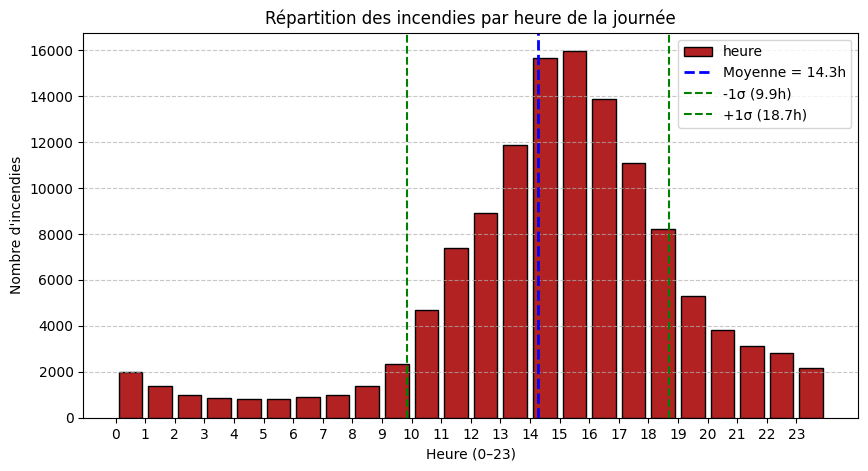

In [47]:
# Statistiques de base
mean_hour = df["heure"].mean()
std_hour = df["heure"].std()

print(f"Moyenne des heures : {mean_hour:.2f}")
print(f"Écart-type des heures : {std_hour:.2f}")

# Histogramme
plt.figure(figsize=(10,5))
df["heure"].plot.hist(
    bins=24, range=(0,24), rwidth=0.8, color="firebrick", edgecolor="black"
)

# Ajouter moyenne et ±1 écart-type
plt.axvline(mean_hour, color="blue", linestyle="--", linewidth=2, label=f"Moyenne = {mean_hour:.1f}h")
plt.axvline(mean_hour - std_hour, color="green", linestyle="--", linewidth=1.5, label=f"-1σ ({mean_hour-std_hour:.1f}h)")
plt.axvline(mean_hour + std_hour, color="green", linestyle="--", linewidth=1.5, label=f"+1σ ({mean_hour+std_hour:.1f}h)")

plt.title("Répartition des incendies par heure de la journée")
plt.xlabel("Heure (0–23)")
plt.ylabel("Nombre d'incendies")
plt.xticks(range(0,24))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()

**Distribution des surfaces brûlées**

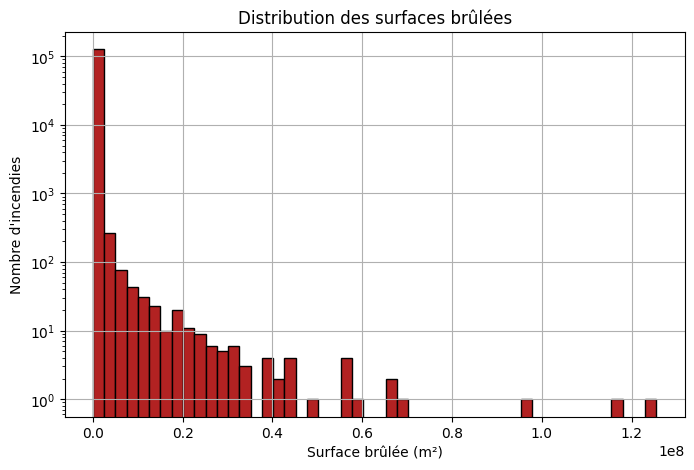

In [48]:
# 🔹 1) Analyse univariée
plt.figure(figsize=(8,5))
df["surface_brulee_m2"].hist(bins=50, color="firebrick", edgecolor="black")
plt.xlabel("Surface brûlée (m²)")
plt.ylabel("Nombre d'incendies")
plt.title("Distribution des surfaces brûlées")
plt.yscale("log")  # car distribution très asymétrique
plt.show()

**Répartition des incendies par année**

In [ ]:
# Répartition des incendies par année

plt.figure(figsize=(12,6))
plt.plot(df["annee"], df["numero_incendie"], marker="o", color="firebrick")

plt.title("Nombre d'incendies par année")
plt.xlabel("Année")
plt.ylabel("Nombre d'incendies")
plt.grid(True)

# espacement tous les 1 ans
plt.xticks(df["annee"][::2], rotation=45)

plt.show()

**Types de peuplements touchés**

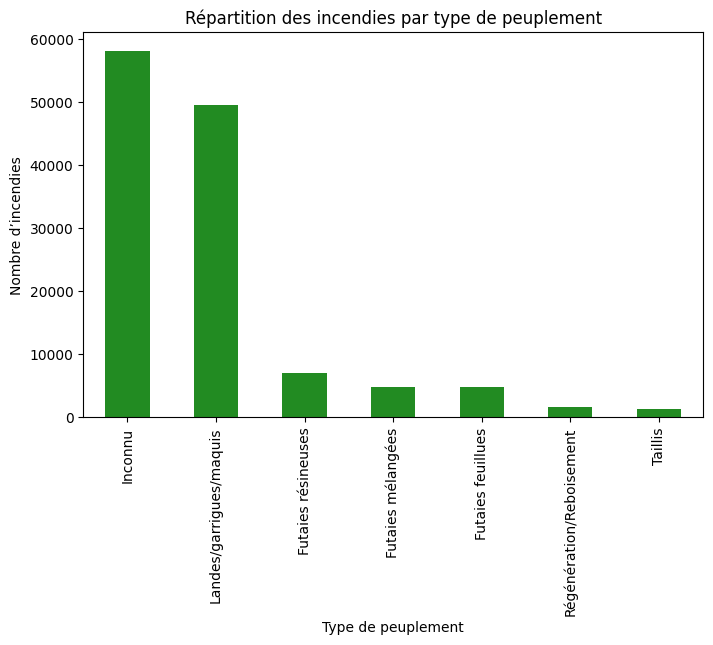

In [50]:
df["type_peuplement_label"].value_counts().plot(
    kind="bar", figsize=(8,5), color="forestgreen"
)
plt.title("Répartition des incendies par type de peuplement")
plt.xlabel("Type de peuplement")
plt.ylabel("Nombre d’incendies")
plt.show()

#### 2) Analyse bivariée


**Année vs nombre d’incendies (tendance temporelle)**

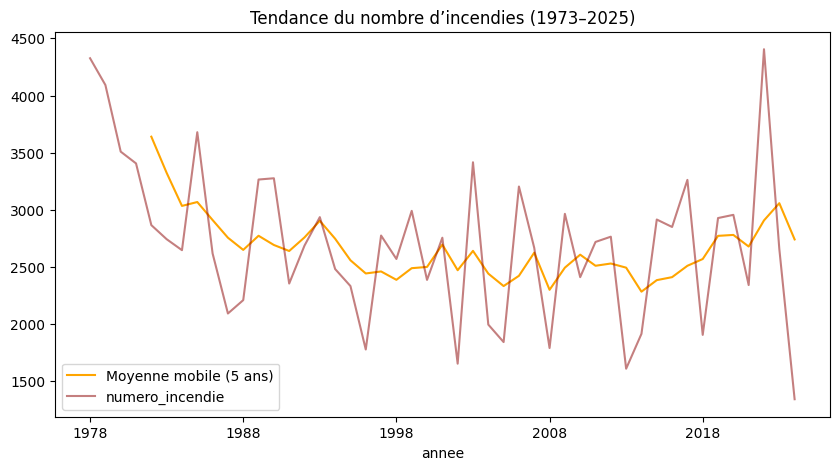

In [51]:
# 2) Analyse bivariée
df_years = df.groupby("annee")["numero_incendie"].count()
df_years.rolling(5).mean().plot(figsize=(10,5), color="orange", label="Moyenne mobile (5 ans)")
df_years.plot(color="darkred", alpha=0.5)
plt.title("Tendance du nombre d’incendies (1973–2025)")
plt.legend()
plt.show()

**Type de peuplement vs surface brûlée**

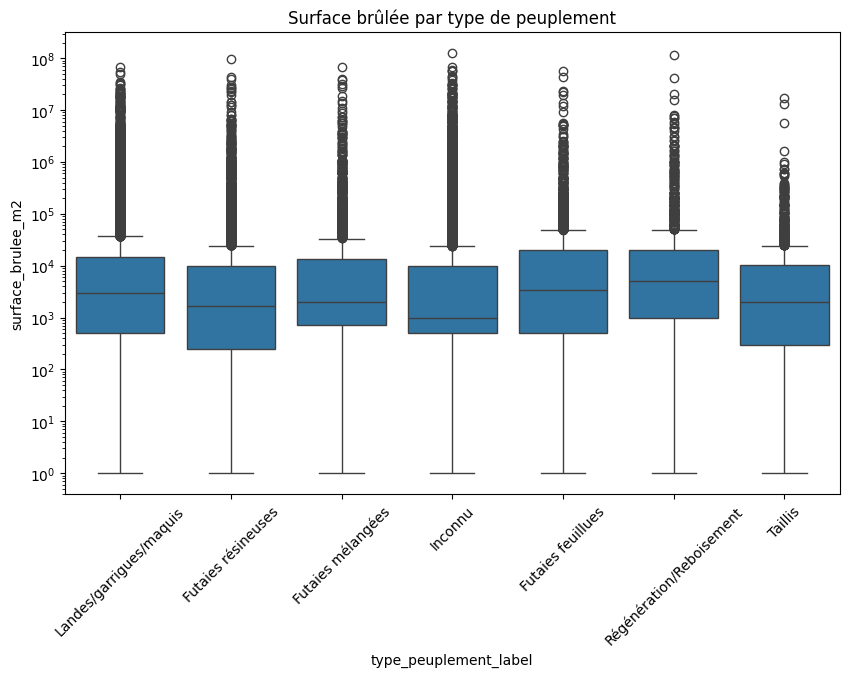

In [52]:
plt.figure(figsize=(10,6))
sns.boxplot(x="type_peuplement_label", y="surface_brulee_m2", data=df)
plt.yscale("log")
plt.title("Surface brûlée par type de peuplement")
plt.xticks(rotation=45)
plt.show()

**Population vs nombre d’incendies**

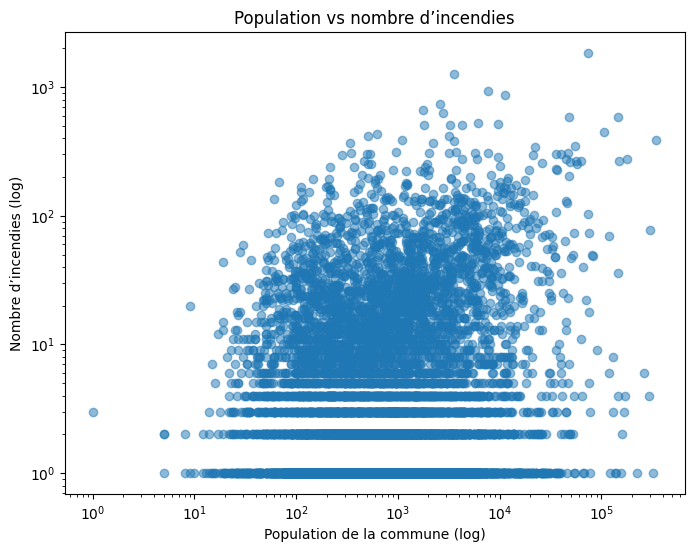

In [53]:
df_pop = df.groupby("commune_incendie").agg({
    "numero_incendie": "count",
    "population_commune": "first"
}).reset_index()

plt.figure(figsize=(8,6))
plt.scatter(df_pop["population_commune"], df_pop["numero_incendie"], alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Population de la commune (log)")
plt.ylabel("Nombre d’incendies (log)")
plt.title("Population vs nombre d’incendies")
plt.show()

#### 3) Analyse multivariée

**Carte des incendies (densité par commune)**

In [54]:
# Création d'une carte centrée sur la France
m = folium.Map(location=[46.5, 2.5], zoom_start=6, tiles="CartoDB positron")

# Boucler sur un échantillon d’incendies pour ne pas surcharger
for _, row in df.sample(500).iterrows():   # <- ajuste le nombre si besoin
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=max(2, min(row["surface_brulee_m2"] / 50000, 15)),  # rayon proportionnel
        color="crimson",
        fill=True,
        fill_opacity=0.6,
        popup=(
            f"<b>Commune :</b> {row['commune_incendie']}<br>"
            f"<b>Surface brûlée :</b> {row['surface_brulee_m2']:,} m²<br>"
            f"<b>Type peuplement :</b> {row['type_peuplement']}"
        )
    ).add_to(m)

m


In [55]:

fig = px.density_mapbox(df, lat="latitude", lon="longitude", z="surface_brulee_m2",
                        radius=10, center=dict(lat=46, lon=2), zoom=3,
                        mapbox_style="carto-positron",
                        title="Densité des incendies en France")
fig.show()


/tmp/ipykernel_82974/1565470305.py:1: DeprecationWarning: *density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.density_mapbox(df, lat="latitude", lon="longitude", z="surface_brulee_m2",


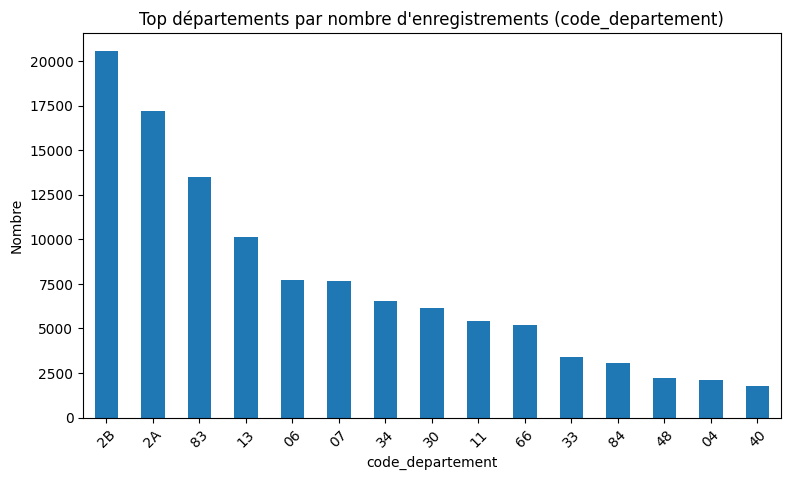

In [56]:
# 9.3) Top départements (si colonne dispo)
dept_col_candidates = [c for c in df.columns if c in ['departement','code_departement','dept','code_dept']]
if dept_col_candidates:
    dcol = dept_col_candidates[0]
    top_dept = df[dcol].astype(str).value_counts().head(15)
    ax = top_dept.plot(kind='bar')
    ax.set_title(f"Top départements par nombre d'enregistrements ({dcol})")
    ax.set_ylabel("Nombre")
    plt.xticks(rotation=45)
    plt.show()


In [57]:
df.columns

Index(['annee', 'numero_incendie', 'code_departement', 'code_insee', 'commune_incendie', 'surface_brulee_m2', 'type_peuplement',
       'nature_incendie', 'commune_ref', 'latitude', 'longitude', 'population_commune', 'superficie_km2', 'densite_population', 'mois',
       'jour', 'heure', 'type_peuplement_label', 'gravite'],
      dtype='object')

In [58]:
# Gestion des outliers
def gerer_outliers(df: pd.DataFrame,
                   lat_range=(41, 51),
                   lon_range=(-5, 10),
                   cols_check=["surface_brulee_m2", "population_commune",
                               "superficie_km2", "densite_population"],
                   col_surface="surface_brulee_m2",
                   create_log=True):
    """
    La gestion des valeurs aberrantes (outliers).

    Étapes :
    --------
    1. Filtrage géographique :
       - Conserve uniquement les communes situées dans la France métropolitaine et la Corse.
       - Défini par lat_range et lon_range (par défaut lat=41–51, lon=-5–10).

    2. Vérification des colonnes numériques :
       - Si des valeurs négatives existent dans les colonnes listées (cols_check),
         elles sont remplacées par NaN.

    3. Transformation logarithmique :
       - Crée une nouvelle variable log-transformée (log1p) pour la surface brûlée.
       - Nommée `surface_brulee_log` si create_log=True.
    """

    
    # 1. Filtrer sur la France métropolitaine + Corse
    df_clean = df[
        (df["latitude"].between(lat_range[0], lat_range[1])) &
        (df["longitude"].between(lon_range[0], lon_range[1]))
    ].copy()

    # 2. Créer une variable log pour surface brûlée
    if create_log and col_surface in df_clean.columns:
        df_clean["surface_brulee_log"] = np.log1p(df_clean[col_surface]).round(2)

    return df_clean


In [59]:
# 1) Cible binaire : incendie majeur > 10 ha (100 000 m²)
df["gravite"] = (df["surface_brulee_m2"] > 100_000).astype(int) # Masque bolean

df_model = df.copy() 

# 2) Sélection des variables explicatives (pas de fuite d'info !)
num_features = ["mois", "jour", "heure", "population_commune", "densite_population", "superficie_km2"]
cat_features = ["type_peuplement", "code_departement"]

X = df_model[num_features + cat_features].copy()
y = df_model["gravite"].copy()

In [60]:
# 3) Prétraitement : imputation num. (médiane) + cat. (modalité la + fréquente) + OneHot
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))
                            ])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop"
)

In [ ]:
def pick_threshold_f1(y_true, y_prob):
    """Seuil qui maximise F1 sur VALIDATION (pas sur test)."""
    p, r, thr = precision_recall_curve(y_true, y_prob)   # thr: len-1
    thr = np.r_[0.0, thr]                                # aligner p/r/thr
    f1 = 2*p*r/(p+r+1e-12)
    j = np.argmax(f1)
    return float(thr[j]), float(p[j]), float(r[j]), float(f1[j])

def evaluate_at_threshold(y_true, y_prob, thr):
    y_hat = (y_prob >= thr).astype(int)
    return {
        "precision": precision_score(y_true, y_hat, zero_division=0),
        "recall":    recall_score(y_true, y_hat, zero_division=0),
        "f1":        f1_score(y_true, y_hat, zero_division=0),
        "roc_auc":   roc_auc_score(y_true, y_prob),
        "pr_auc":    average_precision_score(y_true, y_prob),
        "alerts_%":  100.0 * y_hat.mean(),
        "confusion": confusion_matrix(y_true, y_hat)
    }

# ===========================
# 2) Split train / val / test
# ===========================
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.20, random_state=42, stratify=y_trainval
)

# Fit le préprocesseur sur TRAIN puis transforme les 3 jeux
preprocessor.fit(X_train)
X_train_t = preprocessor.transform(X_train)
X_val_t   = preprocessor.transform(X_val)
X_test_t  = preprocessor.transform(X_test)

# ===========================
# 3) Définition des modèles
# ===========================


# Poids de la classe positive uniquement sur TRAIN
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
spw = neg / max(pos, 1)  # pour XGBoost

models = {
    "logreg_balanced": LogisticRegression(
        max_iter=2000, class_weight="balanced", solver="lbfgs", n_jobs=None
    ),
    "rf_balanced": RandomForestClassifier(
        n_estimators=500, random_state=42, class_weight="balanced", n_jobs=-1
    ),
    "balanced_rf": BalancedRandomForestClassifier(
        n_estimators=300, replacement=False, random_state=42, n_jobs=-1
    ),
    # XGBoost avec early stopping et gestion du déséquilibre
    "xgboost": XGBClassifier(
        n_estimators=2000, learning_rate=0.05,
        max_depth=6, min_child_weight=5,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, reg_alpha=0.0,
        tree_method="hist", random_state=42, n_jobs=-1,
        scale_pos_weight=spw, eval_metric="aucpr"
    )
}

# ===========================
# 4) Entraînement + choix seuil (VAL) + report (TEST)
# ===========================
results = []

for name, model in models.items():
    # Fit
    if name == "xgboost":
        model.fit(
            X_train_t, y_train,
            eval_set=[(X_val_t, y_val)],
            # early_stopping_rounds=50,
            verbose=False
        )
    else:
        model.fit(X_train_t, y_train)

    # Seuil optimal sur VALIDATION (max F1)
    y_val_prob = model.predict_proba(X_val_t)[:, 1]
    thr_opt, P_val, R_val, F1_val = pick_threshold_f1(y_val, y_val_prob)

    # Reporting sur TEST avec ce seuil gelé
    y_test_prob = model.predict_proba(X_test_t)[:, 1]
    metrics = evaluate_at_threshold(y_test, y_test_prob, thr_opt)

    results.append({
        "model": name,
        "thr_opt": round(thr_opt, 4),
        "val_P": round(P_val, 3),
        "val_R": round(R_val, 3),
        "val_F1": round(F1_val, 3),
        "test_P": round(metrics["precision"], 3),
        "test_R": round(metrics["recall"], 3),
        "test_F1": round(metrics["f1"], 3),
        "test_PR_AUC": round(metrics["pr_auc"], 3),
        "test_ROC_AUC": round(metrics["roc_auc"], 3),
        "alerts_%": round(metrics["alerts_%"], 2),
        "confusion": metrics["confusion"]
    })

# Tableau récap (trié par F1-test décroissant)
df_res = pd.DataFrame(results).sort_values("test_F1", ascending=False)
print(df_res[["model","thr_opt","val_F1","test_F1","test_R","test_P","test_PR_AUC","alerts_%"]])
print("\nMatrice(s) de confusion par modèle :")
for r in results:
    print(f"\n[{r['model']}] thr={r['thr_opt']}")
    print(r["confusion"])


/home/kahina/.pyenv/versions/3.10.13/envs/envLaplateforme/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning:

lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



             model  thr_opt  val_F1  test_F1  test_R  test_P  test_PR_AUC  alerts_%
2      balanced_rf   0.6317   0.174    0.187   0.433   0.119        0.120     17.49
3          xgboost   0.4730   0.168    0.185   0.432   0.118        0.127     17.69
1      rf_balanced   0.0720   0.163    0.175   0.448   0.109        0.113     19.87
0  logreg_balanced   0.5515   0.143    0.148   0.561   0.085        0.088     31.67

Matrice(s) de confusion par modèle :

[logreg_balanced] thr=0.5515
[[16858  7374]
 [  540   689]]

[rf_balanced] thr=0.072
[[19724  4508]
 [  678   551]]

[balanced_rf] thr=0.6317
[[20312  3920]
 [  697   532]]

[xgboost] thr=0.473
[[20259  3973]
 [  698   531]]


: 

## 11) Pistes d'amélioration
- **Validation géographique** : entraîner sur des départements et tester sur d’autres.
- **Enrichissement** : ajouter météo (vent, température, sécheresse), végétation (Corine Land Cover), altitude.
- **Modèles** : Gradient Boosting (XGBoost/LightGBM), calibration des probabilités, courbe PR.
- **Clustering spatio-temporel** : DBSCAN/HDBSCAN pour hotspots + saisonnalité (features cycliques plus fines).
- **App Streamlit** : deux onglets *Historique* et *Prédiction* pour une démonstration end‑to‑end.


## Veille technologique

Avant de développer le prototype, une veille technologique a été réalisée pour :

1. **Comprendre les données**
   - Étudier la structure de la BDIFF (Base de Données sur les Incendies de Forêts en France).  
   - Identifier les évolutions depuis 2006 (format, définitions, champs disponibles).  
   - Consulter la documentation officielle : https://bdiff.agriculture.gouv.fr/aide/generalites  

2. **Référentiels géographiques**
   - Explorer les jeux de données INSEE et IGN pour obtenir les codes INSEE, superficies et coordonnées des communes.  
   - Utiliser les ressources de géocodage : https://adresse.data.gouv.fr/outils/telechargements  

3. **Outils techniques**
   - **Python / Pandas** : pour le nettoyage et l’EDA.  
   - **SQLite** : pour consolider et croiser les données incendies et géographiques.  
   - **Streamlit** : pour développer un prototype interactif de cartographie et de prédiction.  
   - **Scikit-learn** : pour les modèles de machine learning (RandomForest, clustering spatio-temporel).  

4. **Travaux existants et bonnes pratiques**
   - Études sur le **clustering spatial (DBSCAN, KMeans)** appliqué aux feux de forêt.  
   - Approches hybrides **spatio-temporelles** dans la littérature scientifique (Portugal, Indonésie, etc.).  
   - Outils de cartographie Python : **Folium, GeoPandas, Plotly**.  

---
